Importing all necessary libraries (can be found in requirements.txt)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset  
from torch.optim import Adam
import seaborn as sns
from pyts.image import GramianAngularField

/home/vanishhhed/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Task 1: Exploratory Data Analysis (EDA) and Preprocessing
___
## 1. Load the Data

##### Columns
1. Total power load -> `DK_load_actual_entose_transparency`(renamed to `load`)
2. Wind generation -> `DK_wind_generation_actual` (renamed to `window_generation`)
3. Solar generation -> `DK_solar_generation_actual` (renamed to `solar_generation`)
___
##### Justification:
In report.pdf

In [3]:
#reading only needed data and renaming the columns for simplicity
dataset = pd.read_csv("./opsd_raw.csv", 
                      usecols=['utc_timestamp', 
                               'DK_load_actual_entsoe_transparency', 
                               'DK_solar_generation_actual', 
                               'DK_wind_generation_actual']
                      ).rename({'utc_timestamp':'date_time', 
                                'DK_load_actual_entsoe_transparency':'load',
                                'DK_solar_generation_actual':'solar_generation',
                                'DK_wind_generation_actual':'wind_generation'},axis=1)


## 2. Data Inspection

In [4]:
print(f"Raw Data:\n Shape: {dataset.shape}\n")
print(f" First 5 rows: \n{dataset.head()}\n")
print(f" Statistic: \n{dataset.describe()}")

Raw Data:
 Shape: (50400, 4)

 First 5 rows: 
                   date_time     load  solar_generation  wind_generation
0  2015-01-01 00:00:00+00:00      NaN               NaN              NaN
1  2015-01-01 01:00:00+00:00  3100.02               NaN          2357.33
2  2015-01-01 02:00:00+00:00  2980.39               NaN          2387.35
3  2015-01-01 03:00:00+00:00  2933.49               NaN          2594.47
4  2015-01-01 04:00:00+00:00  2941.54              0.01          3092.01

 Statistic: 
               load  solar_generation  wind_generation
count  50398.000000      50389.000000     50398.000000
mean    3765.950634        103.578036      1628.998239
std      738.711666        172.006019      1193.925729
min     1692.950000          0.000000         6.370000
25%     3162.282500          0.000000       607.492500
50%     3734.410000          3.500000      1376.695000
75%     4351.695000        144.060000      2492.295000
max     9618.380000        990.190000      7820.580000


### Missing data

In [5]:
#From the previous output we can see that there is some missing values:
#- Load: 50400 - 50398 = 2 
#- Solar_generation: 50400 - 50389 = 11
#- Wind_generation: 50400 - 50398 = 2

#So in total we have 15 missing values. Let's see *how many hours(rows) contain missing values* and see *how our statistic change* if we will drop the data.

missing_indexes = dataset.index.difference(dataset.dropna(how='any').index).to_list()

# print(f"Missing hours: {dataset.shape[0] - dataset.drop(index=missing_indexes).shape[0]}\n")
# print("Dataset with dropped missing values:")
# print(dataset.drop(index=missing_indexes).describe())

# print("\nWe see that if we drop all missing data our statistic won't change in a significant way.\nBut we need to assume that if we will drop the missing hours we will need to drop the whole day.\nSo let's find days containing missing hours and see the statistic change after dropping the days.")
missing_dates = set()
for i in missing_indexes:
    missing_dates.add(str(dataset.iloc[i]['date_time'])[:10])
# print(f"\nDates containing missing values: {missing_dates}\n")

mask = dataset['date_time'].str[:10].isin(missing_dates)
dataset_dropped_days = dataset[~mask]
# print(f"{dataset_dropped_days.shape}\n")
# print(dataset_dropped_days.describe())

# print(f"Even dropping the whole day didn't significantly change the statistic and the percentage of possibly dropped values is small:\n{(len(missing_dates)/(dataset.shape[0]/24))*100 :4f}%")

## 3. Form 24-Hour Arrays

In [6]:
dataset_by_days = dataset_dropped_days.groupby(dataset_dropped_days.index // 24).agg(lambda x: x.tolist())

#Output the start and the end of the day 
#to make sure each daily record lines up with a single date
print("DateStamp of start:          DateStamp of end:")
for i in range(5):
    print(f"{dataset_by_days['date_time'].iloc[i][0]} -> {dataset_by_days['date_time'].iloc[i][-1]}") 


DateStamp of start:          DateStamp of end:
2015-01-02 00:00:00+00:00 -> 2015-01-02 23:00:00+00:00
2015-01-03 00:00:00+00:00 -> 2015-01-03 23:00:00+00:00
2015-01-04 00:00:00+00:00 -> 2015-01-04 23:00:00+00:00
2015-01-05 00:00:00+00:00 -> 2015-01-05 23:00:00+00:00
2015-01-06 00:00:00+00:00 -> 2015-01-06 23:00:00+00:00


## 4. Label Seasons

In [7]:
seasons = {12:"winter", 1:"winter", 2:"winter", 
           3:"spring", 4:"spring", 5:"spring", 
           6:"summer", 7:"summer", 8:"summer", 
           9:"autumn", 10:"autumn", 11:"autumn"}

dataset_by_days['Season'] = dataset_by_days['date_time'].apply(lambda x: seasons.get(int(x[0][5:7])))

#Making sure that label at the intersection of seasons is correct 
print(f"{dataset_by_days['date_time'].iloc[57][0][:10]} -> {dataset_by_days['Season'].iloc[57]}")
print(f"{dataset_by_days['date_time'].iloc[58][0][:10]} -> {dataset_by_days['Season'].iloc[58]}")

print(f"{dataset_by_days['date_time'].iloc[149][0][:10]} -> {dataset_by_days['Season'].iloc[149]}")
print(f"{dataset_by_days['date_time'].iloc[150][0][:10]} -> {dataset_by_days['Season'].iloc[150]}")

print(f"{dataset_by_days['date_time'].iloc[241][0][:10]} -> {dataset_by_days['Season'].iloc[241]}")
print(f"{dataset_by_days['date_time'].iloc[242][0][:10]} -> {dataset_by_days['Season'].iloc[242]}")

print(f"{dataset_by_days['date_time'].iloc[332][0][:10]} -> {dataset_by_days['Season'].iloc[332]}")
print(f"{dataset_by_days['date_time'].iloc[333][0][:10]} -> {dataset_by_days['Season'].iloc[333]}")


dataset_ = dataset_by_days.drop('date_time', axis='columns') 
counts = dataset_['Season'].value_counts()
print(f"\n{counts}")

2015-02-28 -> winter
2015-03-01 -> spring
2015-05-31 -> spring
2015-06-01 -> summer
2015-08-31 -> summer
2015-09-01 -> autumn
2015-11-30 -> autumn
2015-12-01 -> winter

Season
spring    552
summer    552
winter    510
autumn    484
Name: count, dtype: int64


## 5. Train-test split

In [8]:
#Encoding the categorical 'Season' data using OneHotEncoder 
#because seasons don't have ordinal relationship
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(dataset_[['Season']])

onehot_columns = encoder.get_feature_names_out(['Season'])
onehot_df = pd.DataFrame(encoded_data, columns=onehot_columns, index=dataset_.index)

dataset_encoded = pd.concat([dataset_, onehot_df], axis=1).drop('Season', axis=1)

#Splitting data onto Predictors(x) and Target(y) datasets
x = dataset_encoded[['load', 'solar_generation', 'wind_generation']]
y = dataset_encoded[['Season_autumn', 'Season_spring', 'Season_summer', 'Season_winter']]

#splitting the data onto train, validation, test datasets
#using shuffle because our data is ordered (2015->2020) which can badly reflect the results
x_train, x_tmp, y_train, y_tmp = train_test_split(x, y, train_size=0.7, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=42)

# print(x_train.head(3)) # <- to see that the data really shuffled

## 6. Data scaling

Avoiding data leakage is achieved by fitting in scaler only train data. Since our data instance is an array with 24 elements I'll fit three different scalers for three different columns

In [9]:
scalers = {}
scaled_dfs = {'train': x_train.copy(), 'val': x_val.copy(), 'test': x_test.copy()}

for col in x_train.columns:
    scalers[col] = MinMaxScaler(feature_range=(-1, 1)).fit(np.vstack(x_train[col].values))
    # scalers[col] = StandardScaler().fit(np.vstack(x_train[col].values))
    for type_ in ['train', 'val', 'test']:
        values = np.vstack(scaled_dfs[type_][col].values)
        scaled_values = scalers[col].transform(values)
        scaled_dfs[type_][col] = list(scaled_values)

x_train_scaled, x_val_scaled, x_test_scaled = scaled_dfs['train'], scaled_dfs['val'], scaled_dfs['test']

## 7 Brief analysis
**Note:** I'm plotting unscaled data to see real values on graph

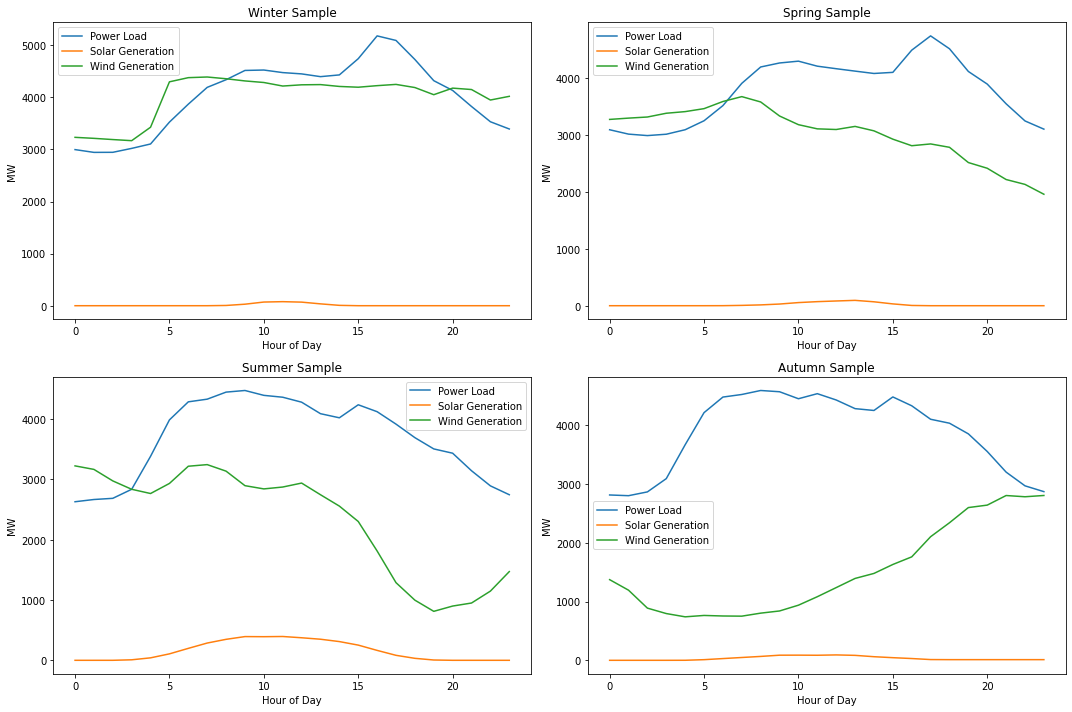

In [10]:
def plot_daily_seasons_stats():
    seasons = ['winter', 'spring', 'summer', 'autumn']
    plt.figure(figsize=(15, 10))
    for i in range(4):
        season = seasons[i]
        day = dataset_.loc[(dataset_['Season'] == season).idxmax()]
        plt.subplot(2, 2, i+1)
        plt.plot(day['load'], label='Power Load')
        plt.plot(day['solar_generation'], label='Solar Generation')
        plt.plot(day['wind_generation'], label='Wind Generation')
        plt.title(f'{season.capitalize()} Sample')
        plt.xlabel('Hour of Day')
        plt.ylabel('MW')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_daily_seasons_stats()

**Observations:**
- Solar Generation is low comparing to wind generation in any season
- Solar Generation is maximum in Summer (5:00 -> 17:00) while Autumn, Winter, Spring Solar Generation is pretty much the same
- Spring and Winter wind generation more stable during the day comparing to the Summer(high in the morning) and Autumn(high in the evening)
- Power Load the highest in the middle of the day (peak is usually around 17:00)
- Power Load peak in Winter is the highest among all other seasons (greater than 5000 MW)  

# Task 2: Baseline MLP (Fully-Connected Network)
___

Converting my data into the torch.Tensor and "flattening" data for correctness of the MLP work with it

In [11]:
def df_to_tensor_flatten(df):
    arrays = [np.concatenate(row) for row in df.values]
    return torch.FloatTensor(np.stack(arrays))

x_train_tensor_flatten = df_to_tensor_flatten(x_train_scaled)
x_val_tensor_flatten = df_to_tensor_flatten(x_val_scaled)
x_test_tensor_flatten = df_to_tensor_flatten(x_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
y_val_tensor = torch.FloatTensor(y_val.values)
y_test_tensor = torch.FloatTensor(y_test.values)

batch_size = 32

train_loader_flatten = DataLoader(TensorDataset(x_train_tensor_flatten, y_train_tensor), batch_size=batch_size)
val_loader_flatten = DataLoader(TensorDataset(x_val_tensor_flatten, y_val_tensor), batch_size=batch_size)
test_loader_flatten = DataLoader(TensorDataset(x_test_tensor_flatten, y_test_tensor), batch_size=batch_size)


Creating MLP class with highly customizable layers structure

In [12]:
class MLP(nn.Module):
    def __init__(self, nodes_in_hiden:list, use_batch_norm:bool=False, dropout_rate:float = -1):
        super(MLP, self).__init__()
        self.INPUT_DIM = 72
        self.OUTPUT_DIM = 4
        
        nodes_in_hiden_copy = nodes_in_hiden[:]
        layers = []
        nodes_in_hiden_copy.insert(0, self.INPUT_DIM)
        nodes_in_hiden_copy.append(self.OUTPUT_DIM)
        
        #creating hiden layers 
        for i in range(len(nodes_in_hiden_copy)-1):            
            layers.append(nn.Linear(nodes_in_hiden_copy[i], nodes_in_hiden_copy[i+1]))
            if nodes_in_hiden_copy[i+1] == 4:
                break
            
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(nodes_in_hiden_copy[i+1]))
            
            layers.append(nn.ReLU())
            
            if dropout_rate != -1 and nodes_in_hiden_copy[i+2] != 4:
                layers.append(nn.Dropout(dropout_rate))
        
        self.model = nn.Sequential(*layers) 
        
    def forward(self, x):
        return self.model(x)


Creating functions to:
- plot the model's training loss and validation accuracy(`plot_model_curves`)
- plot the model's confusion matrix on test dataset(`plot_model_confusion_matrix`)

In [12]:
def plot_model_curves(history:dict):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title(f'Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(history['val_accuracy'])
    plt.title('Validation accuracy')
    
    plt.tight_layout()
    plt.show()
    
    print("Best:")
    print(f"Training Loss: {min(history['train_loss'])}")
    print(f"Validation Loss: {min(history['val_loss'])}")
    print(f"Validation Accuracy: {max(history['val_accuracy'])}")
    
def plot_model_confusion_matrix(test_loss, test_accuracy, all_preds, all_labels):
    seasons = ['winter', 'spring', 'summer', 'autumn']
    matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', xticklabels=seasons, yticklabels=seasons, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    print(f"Test loss: {test_loss}\nTest accuracy: {test_accuracy}")
    

Creating train function

In [ ]:
def train(model, train_loader, val_loader, num_epochs:int = 70,  patience:int = 5, learning_rate:float = 0.001, plot:bool=True):
    
    epoch_no_improve = 0
    
    criterion = nn.CrossEntropyLoss()                         #good for multiclasses classification
    optimizer = Adam(model.parameters(), lr=learning_rate) #great for most of the tasks
    
    #verifying if we have GPU\CPU availible to be used 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy':[]}
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        #training model
        model.train()
        current_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            
            
            loss.backward()
            optimizer.step()
            
            current_loss += loss.item()
        
        #evaluation the result on validation dataset
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted_indexes = torch.max(outputs.data, 1)
                total += labels.size(0)
                
                correct += (predicted_indexes == torch.argmax(labels, dim=1)).sum().item()
        
        #adding the results to history
        epoch_loss = current_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(correct/total)
        
        #saving if the model if it performed better than other 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            epoch_no_improve = 0
        else:
            epoch_no_improve += 1
        
        #printing the epoch and the current results to see the progress in time 
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {correct/total:.4f}')
        print('-' * 50)
    
        if epoch_no_improve >= patience:
            print(f"Early stop was triggered")
            break
            
    
    #plotting the result of training
    if plot:
        plot_model_curves(history)
    
    #taking the best model from the file
    model.load_state_dict(torch.load('best_model.pth'))
    return model, history

Creating test function

In [14]:
def test(model, test_loader, plot: bool=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = nn.CrossEntropyLoss()   #good for multiclass classification

    model.eval()
    test_loss = 0
    total = 0
    correct = 0
    
    all_preds = []
    all_labels =[]
    
    #testing the model on the test dataset    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted_indexes = torch.max(outputs.data, 1)
    
            all_preds.extend(predicted_indexes.numpy())
            all_labels.extend(torch.argmax(labels, dim=1))
            
            total += labels.size(0)
            correct += (predicted_indexes == torch.argmax(labels, dim=1)).sum().item()
    
    #calculating the result
    test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total

    #plotting the confusion matrix 
    if plot:
        plot_model_confusion_matrix(test_loss, test_accuracy, all_preds, all_labels)    
    return test_loss, test_accuracy
    

The block of the code used for finding hyperparameters(amount of neurons at N layers, usage of batch normalization layers, and dropout layer with different rates) for MLP model other parameters were found manually(*)

In [15]:
# from itertools import product

# def hyper_params_search_MLP(train_loader, val_loader):
#     params_names = {
#         'nodes_in_hiden':[[64],[128, 64], [256, 128, 64], [512, 256, 128, 64], [1024, 512, 256, 128, 64]], 
#         'use_batch_norm':[False, True], 
#         'dropout_rate':[-1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
#     }
    
#     best_accuracy = 0
#     best_params = {}
    

#     for params in product(*params_names.values()):
#         current_params = dict(zip(params_names.keys(), params))
    
#         model = MLP(
#             nodes_in_hiden=current_params['nodes_in_hiden'],
#             use_batch_norm=current_params['use_batch_norm'],
#             dropout_rate=current_params['dropout_rate']
#         )
        
#         train(model, train_loader, val_loader, plot=False)
#         accuracy = test(model, val_loader, plot=False)[1]
        
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_params = current_params
        
        
#     print(f"Best params: {best_params}\nBest accuracy: {best_accuracy}")

# hyper_params_search_MLP(train_loader_flatten, val_loader_flatten)

Creating, training and testing the MLP model 

Epoch 1/70
Train Loss: 1.1579 | Val Loss: 0.9185 | Val Acc: 0.6095
--------------------------------------------------
Epoch 2/70
Train Loss: 0.8814 | Val Loss: 0.7854 | Val Acc: 0.6825
--------------------------------------------------
Epoch 3/70
Train Loss: 0.7886 | Val Loss: 0.7186 | Val Acc: 0.6921
--------------------------------------------------
Epoch 4/70
Train Loss: 0.7240 | Val Loss: 0.6776 | Val Acc: 0.7016
--------------------------------------------------
Epoch 5/70
Train Loss: 0.6815 | Val Loss: 0.6511 | Val Acc: 0.6921
--------------------------------------------------
Epoch 6/70
Train Loss: 0.6506 | Val Loss: 0.6306 | Val Acc: 0.7048
--------------------------------------------------
Epoch 7/70
Train Loss: 0.6253 | Val Loss: 0.6136 | Val Acc: 0.7111
--------------------------------------------------
Epoch 8/70
Train Loss: 0.6041 | Val Loss: 0.6000 | Val Acc: 0.7302
--------------------------------------------------
Epoch 9/70
Train Loss: 0.5847 | Val Loss: 0.5886 | Val A

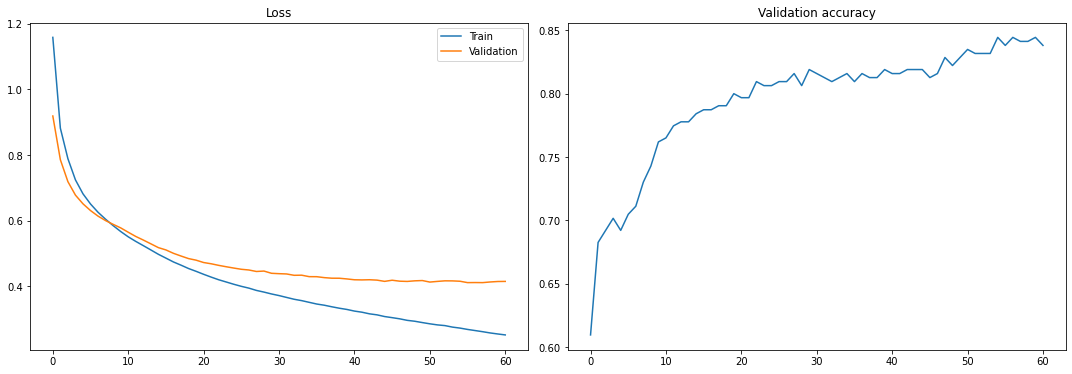

Best:
Training Loss: 0.25195662256168283
Validation Loss: 0.41119197458028794
Validation Accuracy: 0.8444444444444444


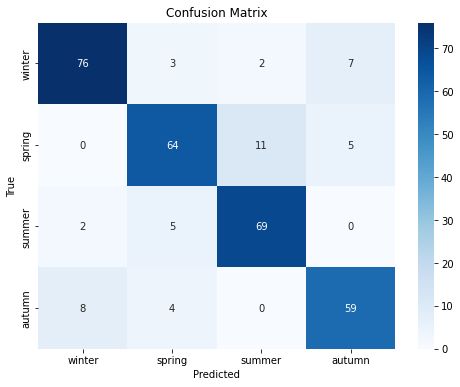

Test loss: 0.3480299711227417
Test accuracy: 0.8507936507936508


In [16]:
mlp = MLP([128, 64])
mlp, history_mlp = train(mlp, train_loader_flatten, val_loader_flatten, learning_rate=0.001)
test_loss_mlp, test_accuracy_mlp = test(mlp, test_loader_flatten)

# Task 3: 1D-CNN on Raw Time-Series

Converting the Datasets into tensors

In [17]:
def df_to_tensor(df):
    tensors = []
    for col in df.columns:
        col_array = np.array(df[col].tolist())
        tensors.append(torch.tensor(col_array, dtype=torch.float32))
    
    result_tensor = torch.stack(tensors, dim=1)    
    return result_tensor

x_train_tensor = df_to_tensor(x_train_scaled)
x_val_tensor   = df_to_tensor(x_val_scaled)
x_test_tensor  = df_to_tensor(x_test_scaled)

batch_size = 32

train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=batch_size)
val_loader = DataLoader(TensorDataset(x_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=batch_size)

Creating class for 1D-CNN

In [18]:
class CNN_1D(nn.Module):
    def __init__(self, kernel_padding:tuple=(5, 2), conv_layer_outs:list=[64, 128]):      
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=3,
                out_channels=conv_layer_outs[0], 
                kernel_size=kernel_padding[0],
                padding=kernel_padding[1],
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=conv_layer_outs[0],
                out_channels=conv_layer_outs[-1], 
                kernel_size=kernel_padding[0],
                padding=kernel_padding[1],
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )       
        self.out = nn.Linear(conv_layer_outs[-1]*6, 4)

    def forward(self, x):
        #(batch_size, 3, 24)->(batch_size, 64, 12)
        x = self.conv1(x)
        #(batch_size, 64, 12)->(batch_size, 128, 6)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x


The block of the code used for finding hyperparameters(kernel_size, padding and neurons at two convolution layers) for 1D-CNN model other parameters were found manually(*)

In [19]:
# from itertools import product

# def hyper_params_search_1D_CNN(train_loader, val_loader):
#     params_names = {
#         'kernel_padding':[(5, 2), (3, 1), (7, 3)], 
#         'conv_layer_outs':[[64, 128], [128, 256], [256, 512]]
#     }
    
#     best_accuracy = 0
#     best_params = {}
    
    
#     for params in product(*params_names.values()):
#         current_params = dict(zip(params_names.keys(), params))
    
#         model = CNN_1D(
#             kernel_padding=current_params['kernel_padding'], 
#             conv_layer_outs=current_params['conv_layer_outs']
#         )
        
#         train(model, train_loader, val_loader, plot=False)
#         accuracy = test(model, val_loader, plot=False)[1]
        
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_params = current_params

#     print(f"Best params: {best_params}\nBest accuracy: {best_accuracy}")

# hyper_params_search_1D_CNN(train_loader, val_loader)

Creating, training and testing the 1D-CNN

Epoch 1/70
Train Loss: 1.0638 | Val Loss: 0.8181 | Val Acc: 0.6476
--------------------------------------------------
Epoch 2/70
Train Loss: 0.7997 | Val Loss: 0.7186 | Val Acc: 0.6952
--------------------------------------------------
Epoch 3/70
Train Loss: 0.7159 | Val Loss: 0.6721 | Val Acc: 0.7111
--------------------------------------------------
Epoch 4/70
Train Loss: 0.6651 | Val Loss: 0.6418 | Val Acc: 0.7333
--------------------------------------------------
Epoch 5/70
Train Loss: 0.6274 | Val Loss: 0.6182 | Val Acc: 0.7460
--------------------------------------------------
Epoch 6/70
Train Loss: 0.5982 | Val Loss: 0.5995 | Val Acc: 0.7524
--------------------------------------------------
Epoch 7/70
Train Loss: 0.5741 | Val Loss: 0.5832 | Val Acc: 0.7524
--------------------------------------------------
Epoch 8/70
Train Loss: 0.5527 | Val Loss: 0.5688 | Val Acc: 0.7619
--------------------------------------------------
Epoch 9/70
Train Loss: 0.5343 | Val Loss: 0.5553 | Val A

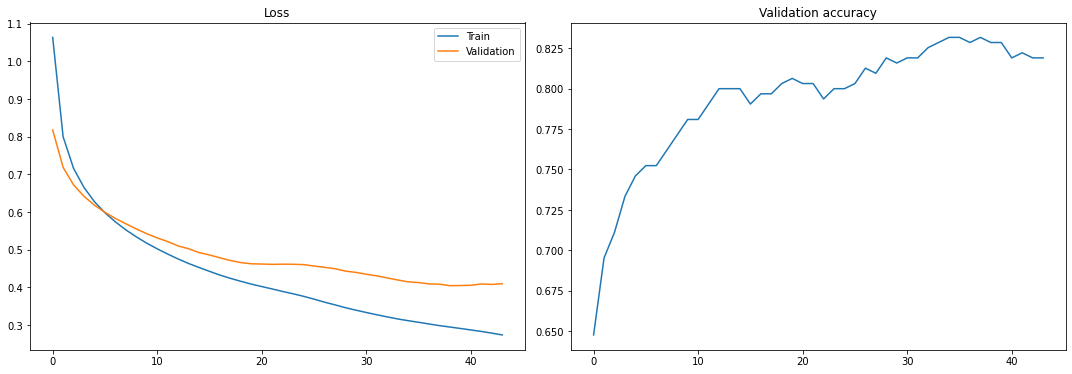

Best:
Training Loss: 0.2739154787167259
Validation Loss: 0.40460692048072816
Validation Accuracy: 0.8317460317460318


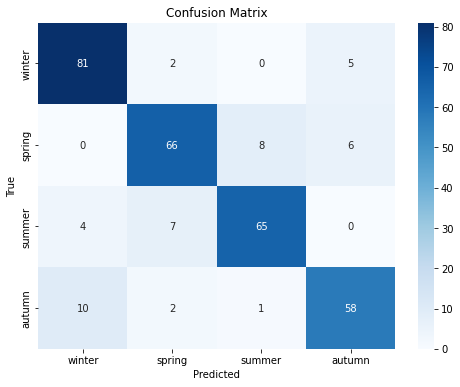

Test loss: 0.35029817521572115
Test accuracy: 0.8571428571428571


In [20]:
cnn_1d = CNN_1D(kernel_padding = (3, 1), conv_layer_outs=[64, 128])
cnn_1d, history_cnn_1d = train(cnn_1d, train_loader, val_loader)
test_loss_cnn_1d, test_accuracy_cnn_1d = test(cnn_1d, test_loader)

Comparing with MLP:
- difference between MLP and 1D-CNN is very small but it's on 1D-CNN favor

In [21]:
print(" "*20 ,"|      MLP", " "*5, "|", " " *2 , "1D-CNN\n", "_"*52)
print(f" Training Loss       |    {min(history_mlp['train_loss']):4f}    |   {min(history_cnn_1d['train_loss']):4f}\n", "_"*52)
print(f" Validarion Loss     |    {min(history_mlp['val_loss']):4f}    |   {min(history_cnn_1d['val_loss']):4f}\n", "_"*52)
print(f" Validation Accuracy |    {max(history_mlp['val_accuracy']):4f}    |   {max(history_cnn_1d['val_accuracy']):4f}\n", "_"*52)
print(f" Test Loss           |    {test_loss_mlp:4f}    |   {test_loss_cnn_1d:4f}\n", "_"*52)
print(f" Test Accuracy       |    {test_accuracy_mlp:4f}    |   {test_accuracy_cnn_1d:4f}\n", "_"*52)

                     |      MLP       |    1D-CNN
 ____________________________________________________
 Training Loss       |    0.251957    |   0.273915
 ____________________________________________________
 Validarion Loss     |    0.411192    |   0.404607
 ____________________________________________________
 Validation Accuracy |    0.844444    |   0.831746
 ____________________________________________________
 Test Loss           |    0.348030    |   0.350298
 ____________________________________________________
 Test Accuracy       |    0.850794    |   0.857143
 ____________________________________________________


# Task 4: 2D Transform & 2D-CNN

Converting the data into 2D"image" using Gramian Angular Field.

*How it works:*
1. Rescales the time series data to be in range [-1, 1]
2. Computes polar coordinates using $arccos()$
3. Computes the $cos()$/$sin()$ of sum/*difference* of the angles (difference chosen due to better performance comparing to summation)

*Reasoning:*
- No problems with non-squared matrices(1d array(24) -> 2d array(24x24))
- generates structured, grid-like output which is efficient for CNN

All information taken from https://pyts.readthedocs.io/en/stable/auto_examples/image/plot_single_gaf.html#sphx-glr-auto-examples-image-plot-single-gaf-py

In [22]:
gaf = GramianAngularField(image_size=24, method='difference')

def process_data(df):
    # Converting each feature independently
    gaf_images = []
    for col in df.columns:
        series = np.array(df[col].tolist())
        
        images = gaf.fit_transform(series)  
        
        images = np.expand_dims(images, axis=1)
        gaf_images.append(images)
    
    #Combining all features into one dataset
    return np.concatenate(gaf_images, axis=1)

x_train_gaf = process_data(x_train_scaled)
x_val_gaf = process_data(x_val_scaled)
x_test_gaf = process_data(x_test_scaled)

x_train_tensor_gaf = torch.FloatTensor(x_train_gaf)
x_val_tensor_gaf = torch.FloatTensor(x_val_gaf)
x_test_tensor_gaf = torch.FloatTensor(x_test_gaf)

batch_size = 32

train_loader_gaf = DataLoader(TensorDataset(x_train_tensor_gaf, y_train_tensor), batch_size=batch_size)
val_loader_gaf = DataLoader(TensorDataset(x_val_tensor_gaf, y_val_tensor), batch_size=batch_size)
test_loader_gaf = DataLoader(TensorDataset(x_test_tensor_gaf, y_test_tensor), batch_size=batch_size)

Creating the 2D-CNN class

In [23]:
class CNN_2D(nn.Module):
    def __init__(self, kernel_padding:tuple=(5, 2), conv_layer_outs:list=[64, 128]):
        super(CNN_2D, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=conv_layer_outs[0],
                kernel_size=kernel_padding[0],
                padding=kernel_padding[1],
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=conv_layer_outs[0],
                out_channels=conv_layer_outs[-1],
                kernel_size=kernel_padding[0],
                padding=kernel_padding[1],
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.out = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(conv_layer_outs[-1] * 6 * 6, conv_layer_outs[-1] * 6),
            nn.ReLU(),
            nn.Linear(conv_layer_outs[-1] * 6, conv_layer_outs[-1]*3),
            nn.ReLU(),
            nn.Linear(conv_layer_outs[-1] * 3, conv_layer_outs[-1]),
            nn.ReLU(),
            nn.Linear(conv_layer_outs[-1], 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )
        
    def forward(self, x):
        #(batch_size, 3, 24, 24)->(batch_size, 64, 12, 12)
        x = self.conv1(x)
        #(batch_size, 64, 12, 12)->(batch_size, 128, 6, 6)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

The block of the code used for finding hyperparameters(kernel_size, padding and neurons at two convolution layers) for 2D-CNN model other parameters were found manually(*)

In [24]:
# from itertools import product

# def hyper_params_search_2D_CNN(train_loader, val_loader):
#     params_names = {
#         'kernel_padding':[(5, 2), (3, 1), (7, 3)], 
#         'conv_layer_outs':[[64, 128], [128, 256], [256, 512]]
#     }
    
#     best_accuracy = 0
#     best_params = {}
    
    
#     for params in product(*params_names.values()):
#         current_params = dict(zip(params_names.keys(), params))
    
#         model = CNN_2D(
#             kernel_padding=current_params['kernel_padding'], 
#             conv_layer_outs=current_params['conv_layer_outs']
#         )
        
#         train(model, train_loader, val_loader, plot=False)
#         accuracy = test(model, val_loader, plot=False)[1]
        
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_params = current_params

#     print(f"Best params: {best_params}\nBest accuracy: {best_accuracy}")

# hyper_params_search_2D_CNN(train_loader_gaf, val_loader_gaf)

Creating, training and testing the 2D-CNN

Epoch 1/70
Train Loss: 1.2798 | Val Loss: 1.0042 | Val Acc: 0.5270
--------------------------------------------------
Epoch 2/70
Train Loss: 0.8983 | Val Loss: 0.8282 | Val Acc: 0.6349
--------------------------------------------------
Epoch 3/70
Train Loss: 0.7679 | Val Loss: 0.7565 | Val Acc: 0.6825
--------------------------------------------------
Epoch 4/70
Train Loss: 0.6777 | Val Loss: 0.6931 | Val Acc: 0.7175
--------------------------------------------------
Epoch 5/70
Train Loss: 0.6015 | Val Loss: 0.6689 | Val Acc: 0.7429
--------------------------------------------------
Epoch 6/70
Train Loss: 0.5340 | Val Loss: 0.6708 | Val Acc: 0.7365
--------------------------------------------------
Epoch 7/70
Train Loss: 0.4907 | Val Loss: 0.6243 | Val Acc: 0.7492
--------------------------------------------------
Epoch 8/70
Train Loss: 0.4638 | Val Loss: 0.5470 | Val Acc: 0.8000
--------------------------------------------------
Epoch 9/70
Train Loss: 0.4355 | Val Loss: 0.4620 | Val A

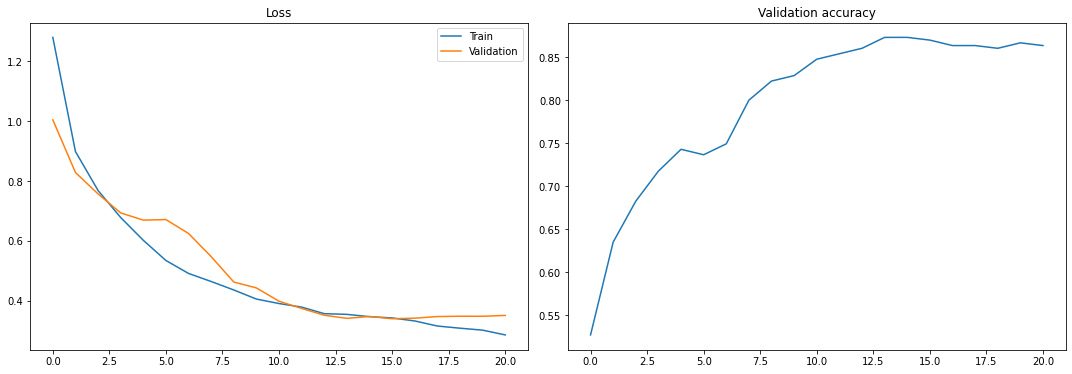

Best:
Training Loss: 0.2851866548476012
Validation Loss: 0.3393313631415367
Validation Accuracy: 0.873015873015873


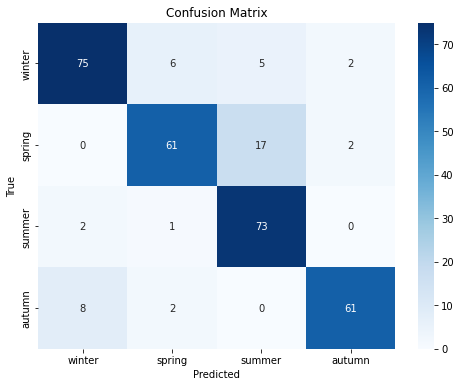

Test loss: 0.35630379766225817
Test accuracy: 0.8571428571428571


In [25]:
cnn_2d = CNN_2D()
cnn_2d, history_cnn_2d = train(cnn_2d, train_loader_gaf, val_loader_gaf, learning_rate=0.0001)
test_loss_cnn_2d, test_accuracy_cnn_2d = test(cnn_2d, test_loader_gaf)

In [1]:
cnn_2d

NameError: name 'cnn_2d' is not defined

Comparison with the MLP and 1D-CNN:
- 

In [26]:
print(" "*20 ,"|      MLP       |     1D-CNN     |     2D-CNN\n", "_"*72)
print(f" Training Loss       |    {min(history_mlp['train_loss']):4f}    |    {min(history_cnn_1d['train_loss']):4f}    |    {min(history_cnn_2d['train_loss']):4f}\n", "_"*72)
print(f" Validarion Loss     |    {min(history_mlp['val_loss']):4f}    |    {min(history_cnn_1d['val_loss']):4f}    |    {min(history_cnn_2d['val_loss']):4f}\n", "_"*72)
print(f" Validation Accuracy |    {max(history_mlp['val_accuracy']):4f}    |    {max(history_cnn_1d['val_accuracy']):4f}    |    {max(history_cnn_2d['val_accuracy']):4f}\n", "_"*72)
print(f" Test Loss           |    {test_loss_mlp:4f}    |    {test_loss_cnn_1d:4f}    |    {test_loss_cnn_2d:4f}\n", "_"*72)
print(f" Test Accuracy       |    {test_accuracy_mlp:4f}    |    {test_accuracy_cnn_1d:4f}    |    {test_accuracy_cnn_2d:4f}\n", "_"*72)

                     |      MLP       |     1D-CNN     |     2D-CNN
 ________________________________________________________________________
 Training Loss       |    0.251957    |    0.273915    |    0.285187
 ________________________________________________________________________
 Validarion Loss     |    0.411192    |    0.404607    |    0.339331
 ________________________________________________________________________
 Validation Accuracy |    0.844444    |    0.831746    |    0.873016
 ________________________________________________________________________
 Test Loss           |    0.348030    |    0.350298    |    0.356304
 ________________________________________________________________________
 Test Accuracy       |    0.850794    |    0.857143    |    0.857143
 ________________________________________________________________________


- 2D-CNN achieved ~3% higher validation accuracy than MLP and ~3.5% higher than 1D-CNN.
- Test accuracy followed the same trend but shown not significant difference.
- Training, validation, test losses were lower for 2D-CNN, indicating better generalization.

I think it happened due to 2D-structure of input data since CNN are mostly used for working with images.